In [1]:
import numpy as np 
import jax.numpy as jnp
import jax.tree_util as jtu
import mctx
from jax import random as jr
from jax.scipy.special import logsumexp

import numpy as np

from pymdp.jax.envs.generalized_tmaze import (
    GeneralizedTMazeEnv, parse_maze, render 
)

from pymdp.jax.agent import Agent as AIFAgent
from tmp_mcts import make_aif_recurrent_fn, rollout

In [2]:
# make animation
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.animation as animation
from IPython.display import HTML

def animate(images, savefile=None):
    fig, ax = plt.subplots()

    sns.despine(fig, left=True, bottom=True)
    ax.set_xticks([])
    ax.set_yticks([])

    # ims is a list of lists, each row is a list of artists to draw in the
    # current frame; here we are just animating one artist, the image, in
    # each frame
    frames = []
    for i, img in enumerate(images):
        im = ax.imshow(img, animated=True)
        if i == 0:
            ax.imshow(img)  # show an initial one first
        frames.append([im])

    ani = animation.ArtistAnimation(fig, frames, interval=1000, blit=True,
                                    repeat_delay=1000)

    # To save the animation, use e.g.
    if savefile is not None:
        ani.save(savefile)

    plt.close(ani._fig)

    return ani

### Grid world (generalized TMaze) generative process

In this example we create a simple square environment, where multiple cues are present, and multiple reward pairs. Each cue indicates the location of one of the reward pairs. 

The agent is can move in the grid world using actions up, down, left and right, and observes the current tile it is at. 

The grid world is specified by a matrix using the following labels: 

```
0: Empty space
1: The initial position of the agent
2: Walls
3 + i: Cue for reward i
4 + i: Potential reward location i 1
4 + i: Potential reward location i 2
```

2024-06-14 11:15:54.464785: W external/xla/xla/service/gpu/nvptx_compiler.cc:763] The NVIDIA driver's CUDA version is 12.4 which is older than the ptxas CUDA version (12.5.40). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


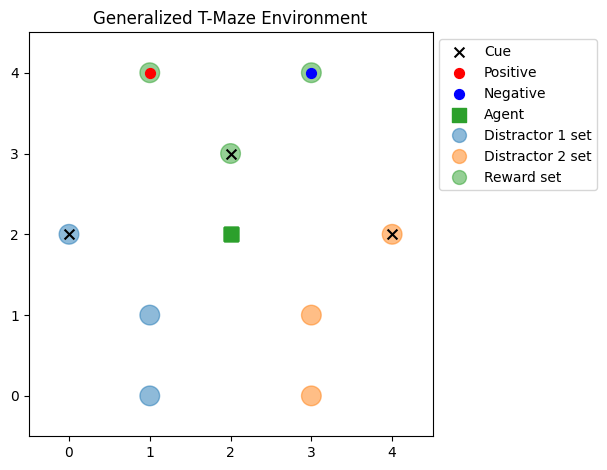

In [3]:
def get_maze_matrix(size='small'):
    if size == 'small':
        M = np.zeros((3, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6

        # Set the initial position
        M[2,3] = 1
    
    elif size == 'medium':
        M = np.zeros((5, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8
        M[4,1] = 10
        M[4,3] = 11

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6
        M[3,2] = 9

        # Set the initial position
        M[2,2] = 1
    
    elif size == 'large':
        M = np.zeros((7, 5))

        # Set the reward locations
        M[0,1] = 4
        M[1,1] = 5
        M[1,3] = 7
        M[0,3] = 8
        M[5,1] = 10
        M[6,1] = 11
        M[5,3] = 13
        M[6,3] = 14

        # Set the cue locations
        M[2,0] = 3
        M[2,4] = 6
        M[4,0] = 9
        M[4,4] = 12

        # Set the initial position
        M[3,2] = 1
    
    else:
        M = np.zeros((10, 10))
        # Set the reward locations
        M[8,8] = 4
        M[8,7] = 5
        M[7,8] = 7
        M[6,8] = 8
        M[8,6] = 10
        M[7,7] = 11
        M[7,6] = 13
        M[6,7] = 14
        M[8,5] = 16
        M[5,8] = 17
        M[6,6] = 19
        M[6,5] = 20
        M[5,6] = 22
        M[5,7] = 23
        M[5,5] = 25
        M[5,4] = 26
        M[6,0] = 28
        M[5,1] = 29
        # Set the cue locations
        M[2,6] = 3
        M[2,7] = 6
        M[2,8] = 9
        M[1,3] = 12
        M[1,7] = 15
        M[1,4] = 18
        M[1,5] = 21
        M[1,6] = 24
        M[5,0] = 27
        # Set the initial position
        M[0,0] = 1

    return M

M = get_maze_matrix('medium')
env_info_m = parse_maze(M)
tmaze_env_m = GeneralizedTMazeEnv(env_info_m, batch_size=5)

render(env_info_m, tmaze_env_m);

#### Create the agent. 

The PyMDPEnv class consists of a params dict that contains the A, B, and D vectors of the environment. We initialize our agent using the same parameters. This means that the agent has full knowledge about the environment transitions, and likelihoods. We initialize the agent with a flat prior, i.e. it does not know where it, or the reward is. Finally, we set the C vector to have a preference only over the rewarding observation of cue-reward pair 1 (i.e. C[-1] = [0, 1, -2]  and zero for all other modalities). 

In [4]:
def make_aif_agent(tmaze_env):
    A = [a.copy() for a in tmaze_env.params["A"]]
    B = [b.copy() for b in tmaze_env.params["B"]]
    A_dependencies = tmaze_env.dependencies["A"]
    B_dependencies = tmaze_env.dependencies["B"]

    # [position], [cue], [reward]
    C = [jnp.zeros(a.shape[:2]) for a in A]

    rewarding_modality = -1 # 2 + env_info["num_cues"]

    C[rewarding_modality] = C[rewarding_modality].at[:, 1].set(1.0)
    C[rewarding_modality] = C[rewarding_modality].at[:, 2].set(-2.0)

    # uncomment to normalize C. For now this changes the behaviour of the agent. 
    # C = jtu.tree_map(lambda x: x - logsumexp(x, -1, keepdims=True), C)

    D = [jnp.ones(b.shape[:2]) / b.shape[1] for b in B]

    agent = AIFAgent(
        A, B, C, D, 
        E=None,
        pA=None,
        pB=None,
        policy_len=1,
        A_dependencies=A_dependencies, 
        B_dependencies=B_dependencies,
        use_utility=True,
        use_states_info_gain=True,
        sampling_mode='full'
    )

    return agent

### MCTS based policy search

Here we defined the sofisticated active inference monte-carlo tree search policies using the [mctx](https://github.com/google-deepmind/mctx) package for google deep mind. Although other algorithms are provided in mctx package here we will use only Gumbel based planning algorithm intoroduced in [Policy improvement by planning with Gumbel](https://openreview.net/forum?id=bERaNdoegnO).

In [5]:
def make_si_policy_search(search_algo, max_depth = 6, num_simulations = 4096):
    def si_policy(rng_key, agent, beliefs):
        
        # remove time dimension 
        embedding = jtu.tree_map(lambda x: x[:, 0], beliefs)
        root = mctx.RootFnOutput(
            prior_logits=jnp.log(agent.E),
            value=jnp.zeros((agent.batch_size)),
            embedding=embedding,
        )

        recurrent_fn = make_aif_recurrent_fn()

        policy_output = search_algo(
            agent,
            rng_key,
            root,
            recurrent_fn,
            num_simulations=num_simulations,
            max_num_considered_actions=len(agent.policies),
            max_depth=max_depth
        )

        return policy_output.action_weights, policy_output
    
    return si_policy

### Run active inference

In [6]:
%%capture
images = [render(env_info_m, tmaze_env_m)]

timesteps = 10
key = jr.PRNGKey(0)
si_policy = make_si_policy_search(mctx.gumbel_muzero_policy, max_depth=5, num_simulations=4096)
agent = make_aif_agent(tmaze_env_m)
_, info, _ = rollout(si_policy, agent, tmaze_env_m, num_timesteps=timesteps, rng_key=key)

for t in range(timesteps):
    env_state = jtu.tree_map(lambda x: x[:, t], info['env'])
    plt.figure()
    images.append( np.array(render(env_info_m, env_state, show_img=False)) )

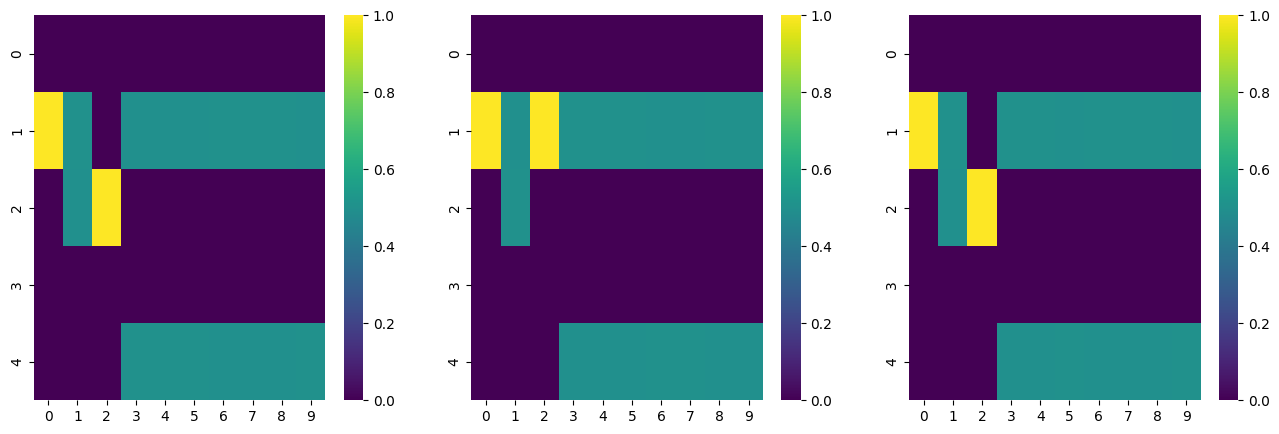

In [7]:
# plot q(u_t) for each time step
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qpi'][i].T, cmap='viridis', ax=axes[i])

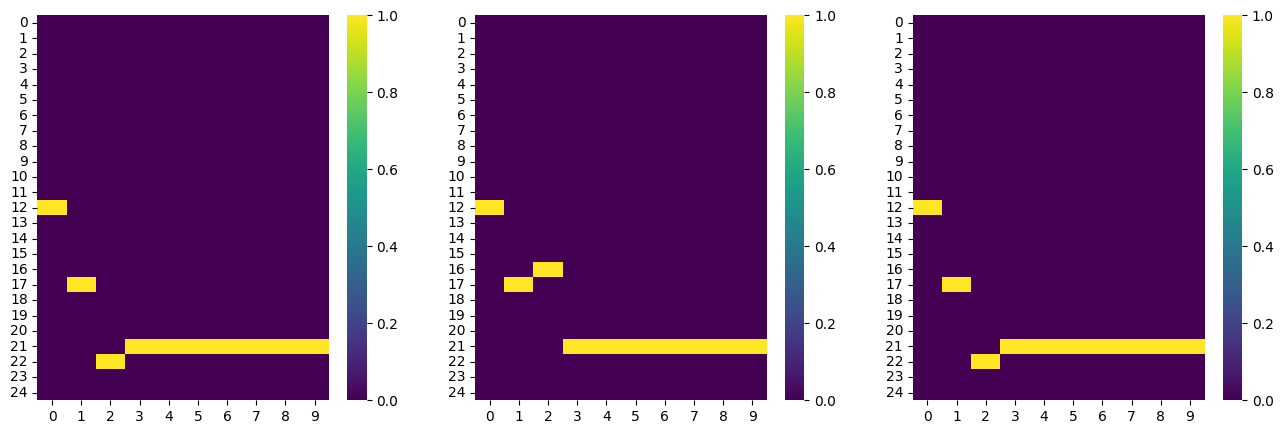

In [8]:
# plot beliefs over locations for each time steps
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qs'][0][i].T, cmap='viridis', ax=axes[i])

In [9]:
ani = animate(images)

HTML(ani.to_html5_video())

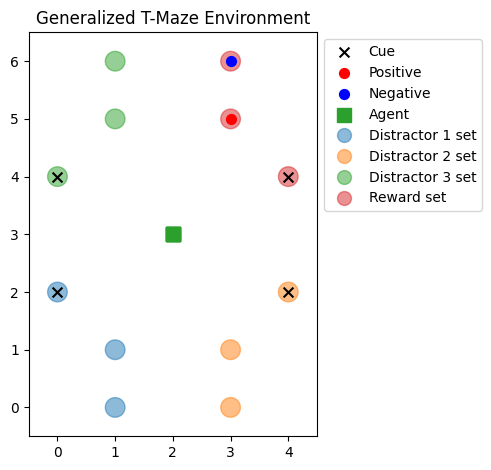

In [10]:
M = get_maze_matrix('large')
env_info_l = parse_maze(M)
tmaze_env_l = GeneralizedTMazeEnv(env_info_l, batch_size=5)
render(env_info_l, tmaze_env_l);

In [11]:
%%capture
images = [render(env_info_l, tmaze_env_l)]

timesteps = 10
key = jr.PRNGKey(0)
si_policy = make_si_policy_search(mctx.gumbel_muzero_policy, max_depth=6, num_simulations=4096)
agent = make_aif_agent(tmaze_env_l)
_, info, _ = rollout(si_policy, agent, tmaze_env_l, num_timesteps=timesteps, rng_key=key)

for t in range(timesteps):
    env_state = jtu.tree_map(lambda x: x[:, t], info['env'])
    plt.figure()
    images.append( np.array(render(env_info_l, env_state, show_img=False)) )

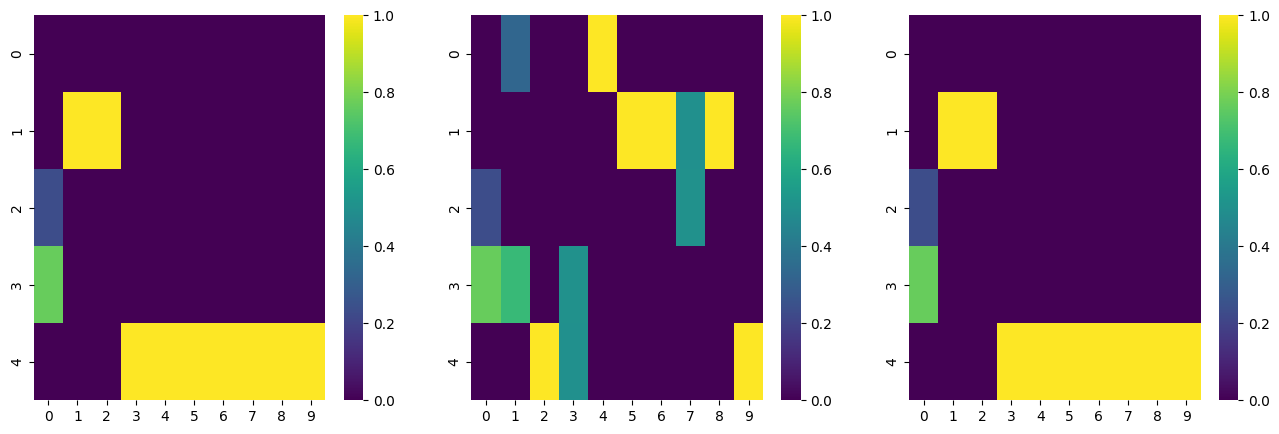

In [12]:
# plot q(u_t) for each time step
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qpi'][i].T, cmap='viridis', ax=axes[i])

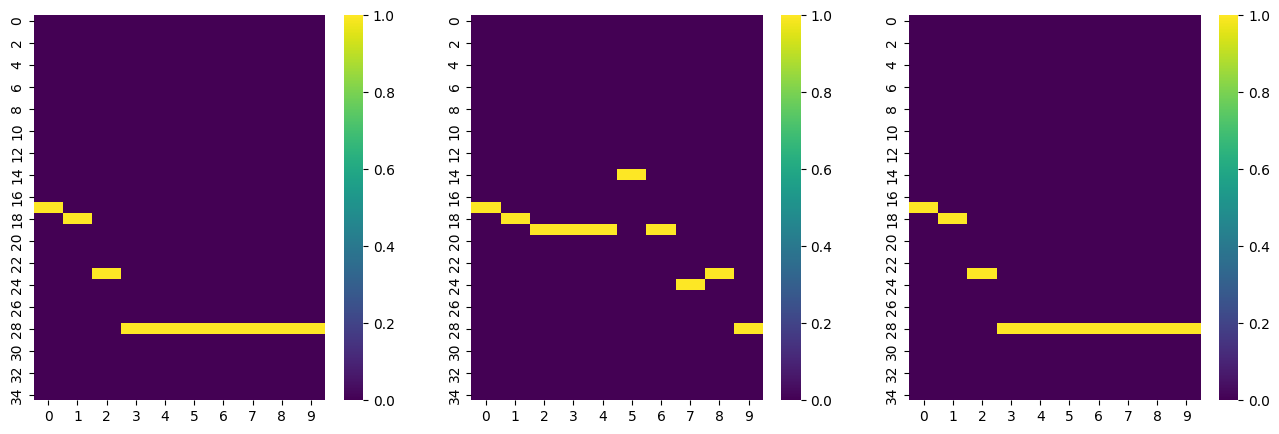

In [13]:
# plot beliefs over locations for each time step
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
for i in range(3):
    sns.heatmap(info['qs'][0][i].T, cmap='viridis', ax=axes[i])

In [14]:
ani = animate(images)
HTML(ani.to_html5_video())